In [1]:
#!/usr/bin/py

import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh
from tsfresh.utilities.distribution import MultiprocessingDistributor

In [2]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [3]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [4]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [5]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [6]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [7]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    

        
    
    

In [ ]:
def calcuate_RMS_Value(data,axis,file):
    RMS_Value = []
    d = []

    if axis in file:
                # Extract features for axis1
        print(file)
        
        data = series.normalized_torque()
        d = np.concatenate((data, d), axis=None)
        RMS_Value.append(tsfresh.feature_extraction.feature_calculators.root_mean_square(d))
        return RMS_Value

<class 'str'>
04-64139_ROB_1_axis1_MCC.txt


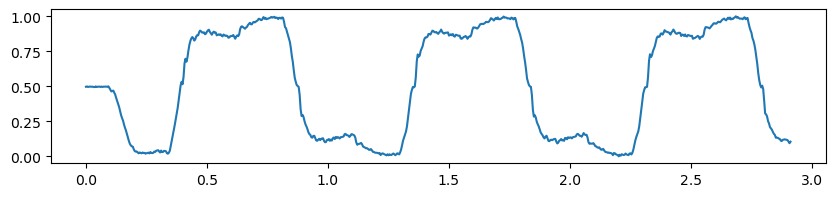

0.6389362012341817
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:00:18
04-64139_ROB_1_axis2_MCC.txt


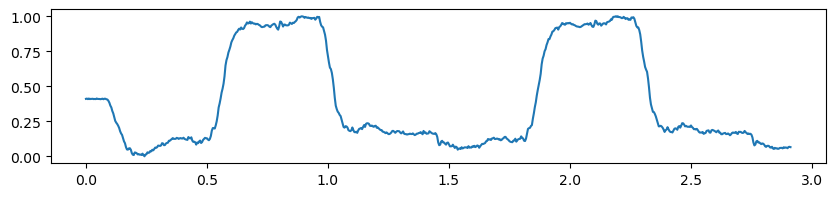

0.5884412400785716
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:00:42
04-64139_ROB_1_axis3_MCC.txt


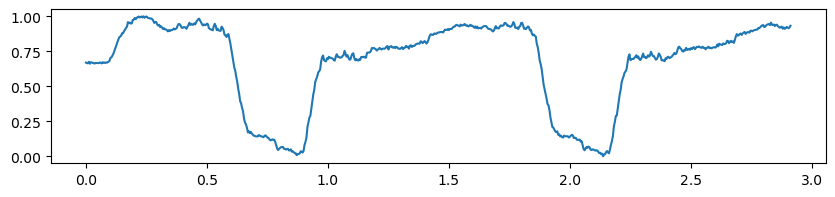

0.6433389714964045
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:01:07
04-64139_ROB_1_axis4_MCC.txt


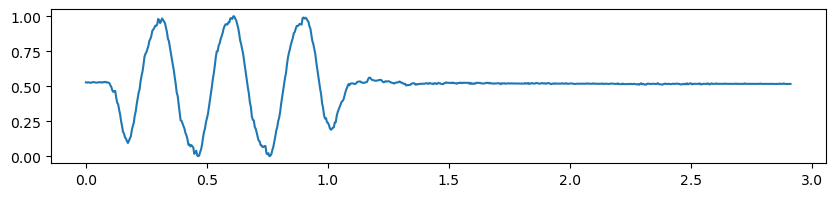

0.6208099135927977
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:01:30
04-64139_ROB_1_axis5_MCC.txt


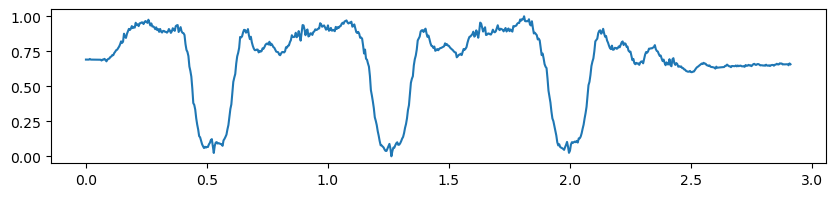

0.6432270468104506
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:01:54
04-64139_ROB_1_axis6_MCC.txt


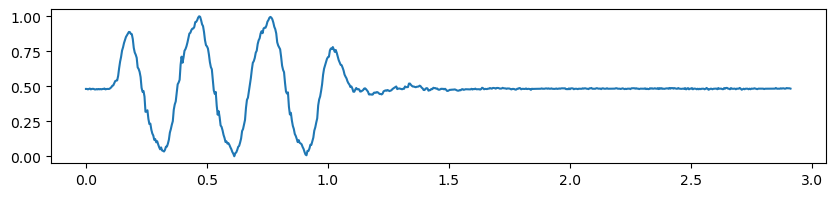

0.6243536763519305
*** Feature extraction started ***
60


C:\Temp\ipykernel_13748\289758067.py:27: UserWarning: Using default sampling frequency set in configuration file.
  feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))


2017-09-20 18:02:18


In [60]:
File_test = '04-64139_DIAGDATA_20170920_180212__MCC.zip'
feature_list_axis1 = []
d = []

with ZipFile(File_test) as File:
    print(type(File_test))
    for file in File.namelist():
        print(file)
        with File.open(file) as f:
            header = read_header(f)
            date = header['date_time']
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            plt.figure(figsize=(10,2)) 
            t = series.normalized_torque()
            d = np.concatenate((t, d), axis=None)
            
            time_index = series.time_index
            plt.plot(time_index, t)
            plt.show()   
            #Caculate RMS
            test = tsfresh.feature_extraction.feature_calculators.root_mean_square(d)
            print(test)
            # Extract features for axis1
           
            feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))
            result = pd.concat(feature_list_axis1)
            print(date)
                
            


In [ ]:
test

In [ ]:
print(type(t))

In [ ]:
result['0_Root mean square']

In [ ]:
from scipy import signal
sig1_fft = np.fft.fft(t)
fvec1 = np.fft.fftfreq(time_index.shape[-1],0.02)
n = t.size
freq = np.fft.fftfreq(n, d=0.01)

In [ ]:
plt.close()
plt.plot(freq,np.abs(sig1_fft)) # Note that we're looking at the absolute value of the complex-valued fft
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [61]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
RMS_Value=pd.DataFrame(columns=columns)
Skewness_value = pd.DataFrame(columns=columns)
Kurtosis_value = pd.DataFrame(columns=columns)
Crest_factor = pd.DataFrame(columns=columns)
i = 0    
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    with ZipFile(route) as File:
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                data = read_data(f)
                mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                if ax1 in file:
                # Extract features for axis1
                    DATA1 = series.normalized_torque()
                    d1 = np.concatenate((DATA1, d1), axis=None)
                    RMS_Value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
                    Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1)
                    Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1)
                    Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
                elif ax2 in file:
                # Extract features for axis1
                    DATA2 = series.normalized_torque()
                    d2 = np.concatenate((DATA2, d2), axis=None)
                    RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
                    Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2)
                    Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2)
                    Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
                elif ax3 in file:
                # Extract features for axis1
                    DATA3 = series.normalized_torque()
                    d3 = np.concatenate((DATA3, d3), axis=None)
                    RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
                    Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3)
                    Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3)
                    Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
                elif ax4 in file:
                # Extract features for axis1
                    DATA4 = series.normalized_torque()
                    d4 = np.concatenate((DATA4, d4), axis=None)
                    RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
                    Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4)
                    Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4)
                    Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
                elif ax5 in file:
                # Extract features for axis1
                    DATA5 = series.normalized_torque()
                    d5 = np.concatenate((DATA5, d5), axis=None)
                    RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
                    Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5)
                    Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5)
                    Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
                elif ax6 in file:
                # Extract features for axis1
                    DATA6 = series.normalized_torque()
                    d6 = np.concatenate((DATA6, d6), axis=None)
                    RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
                    Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6)
                    Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6)
                    Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
        i = i + 1
               

In [46]:

RMS_Value

,axis1,axis2,axis3,axis4,axis5,axis6
0,0.636022,0.531522,0.737622,0.548087,0.729029,0.517997
1,0.638018,0.531958,0.742069,0.548817,0.726598,0.518268
2,0.637353,0.531812,0.74059,0.548574,0.727409,0.518178
3,0.637641,0.532062,0.741801,0.548177,0.724999,0.518409
4,0.637704,0.531931,0.742011,0.547925,0.725108,0.518346
...,...,...,...,...,...,...
1782,0.637167,0.537684,0.743902,0.546588,0.715905,0.520454
1783,0.637164,0.537675,0.743904,0.546589,0.715908,0.520454
1784,0.637163,0.537682,0.743905,0.546589,0.715903,0.520454
1785,0.637162,0.537691,0.743909,0.546593,0.715903,0.520454


<AxesSubplot:>

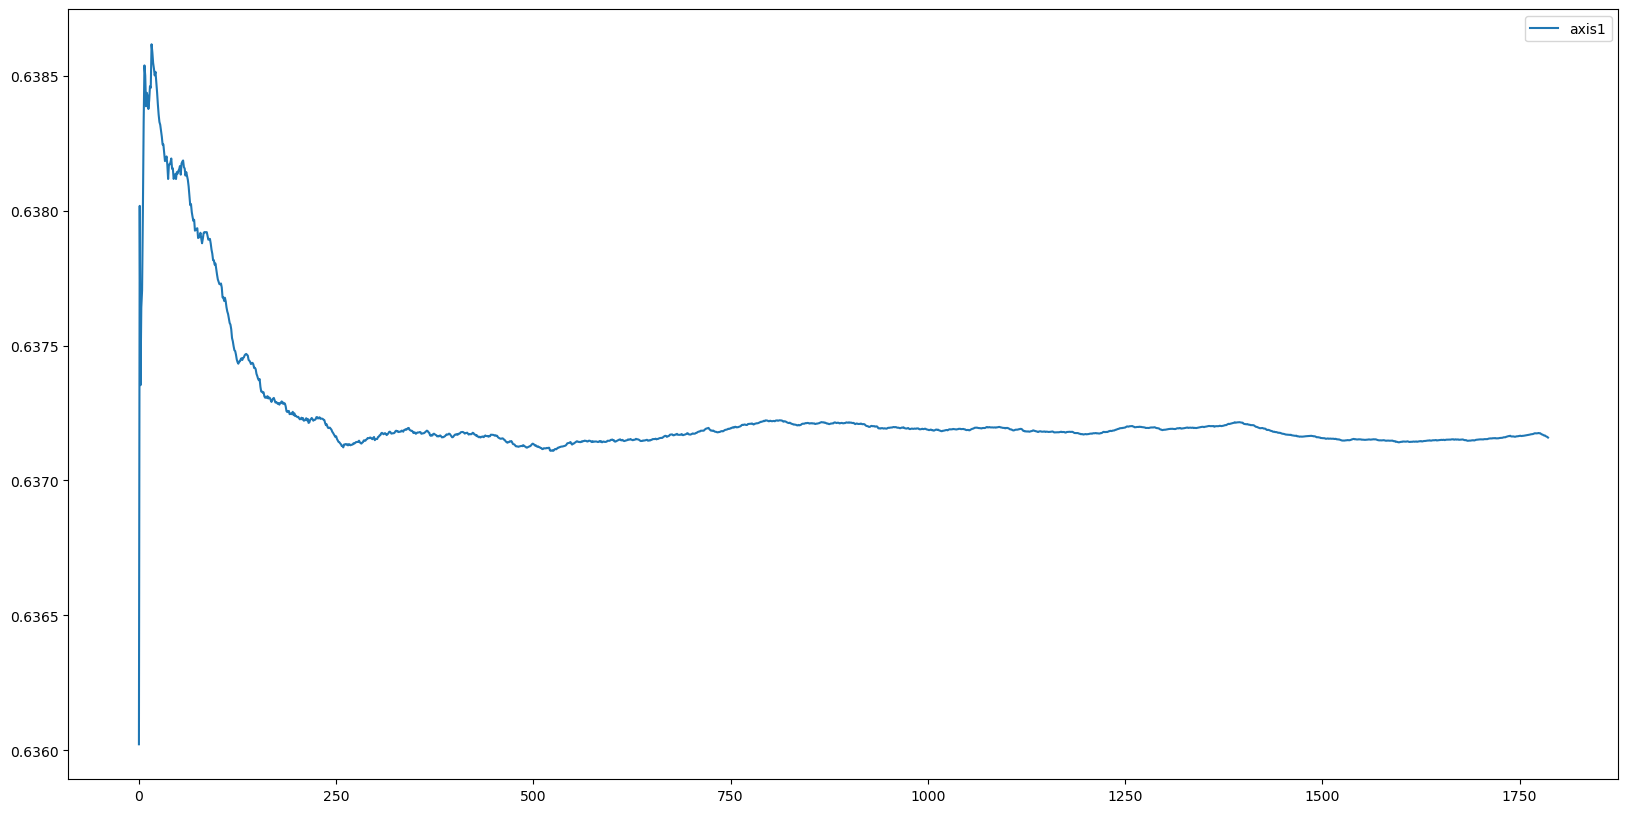

In [59]:
RMS_Value.plot(y='axis1', figsize=(20,10))

<AxesSubplot:>

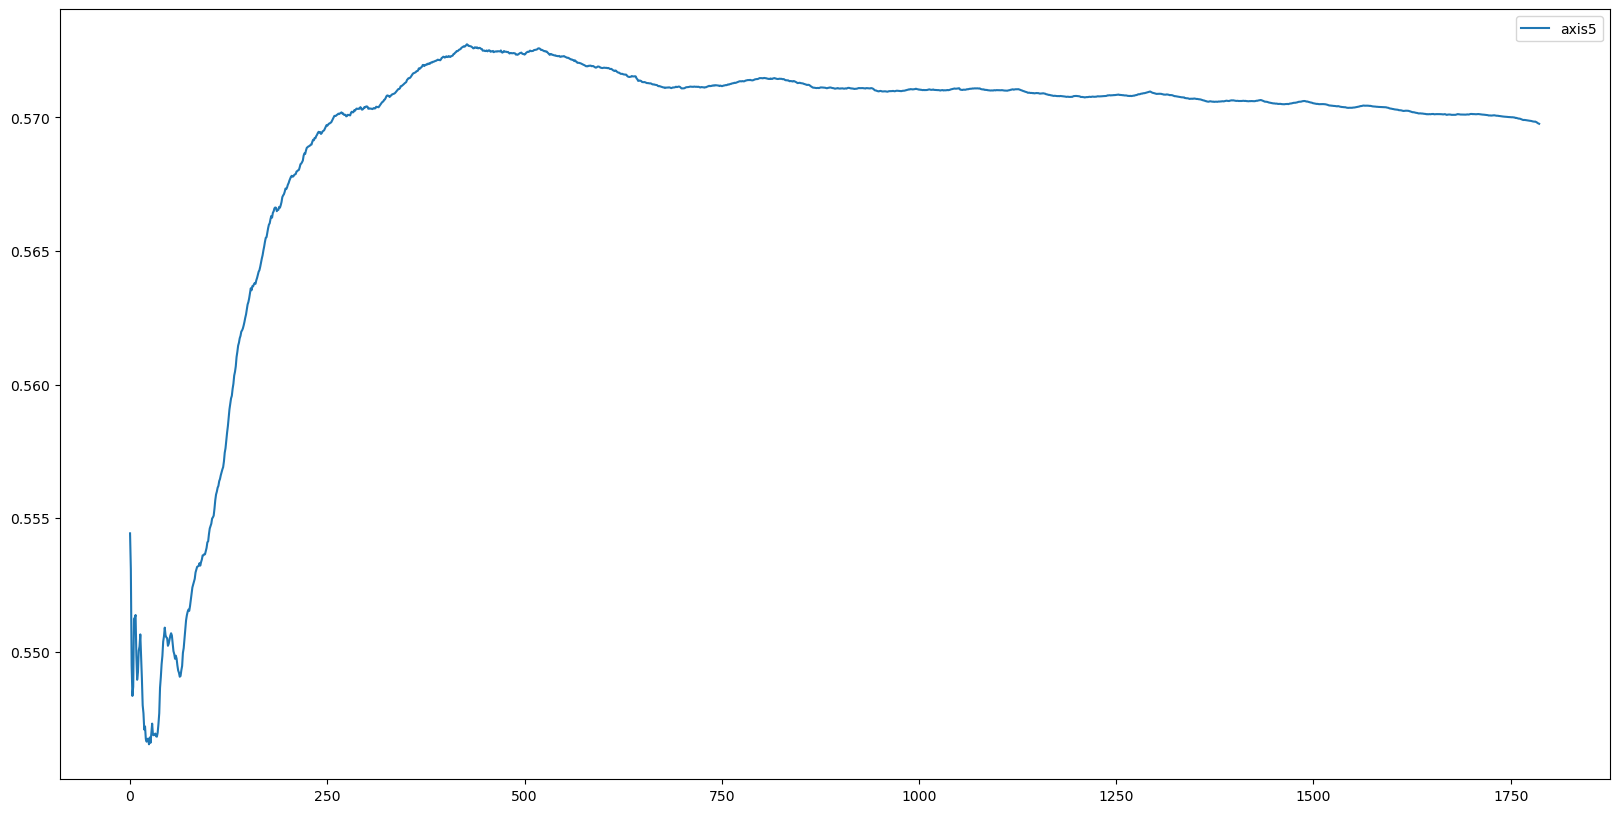

In [67]:
Kurtosis_value
Kurtosis_value.plot(y='axis5', figsize=(20,10))

<AxesSubplot:>

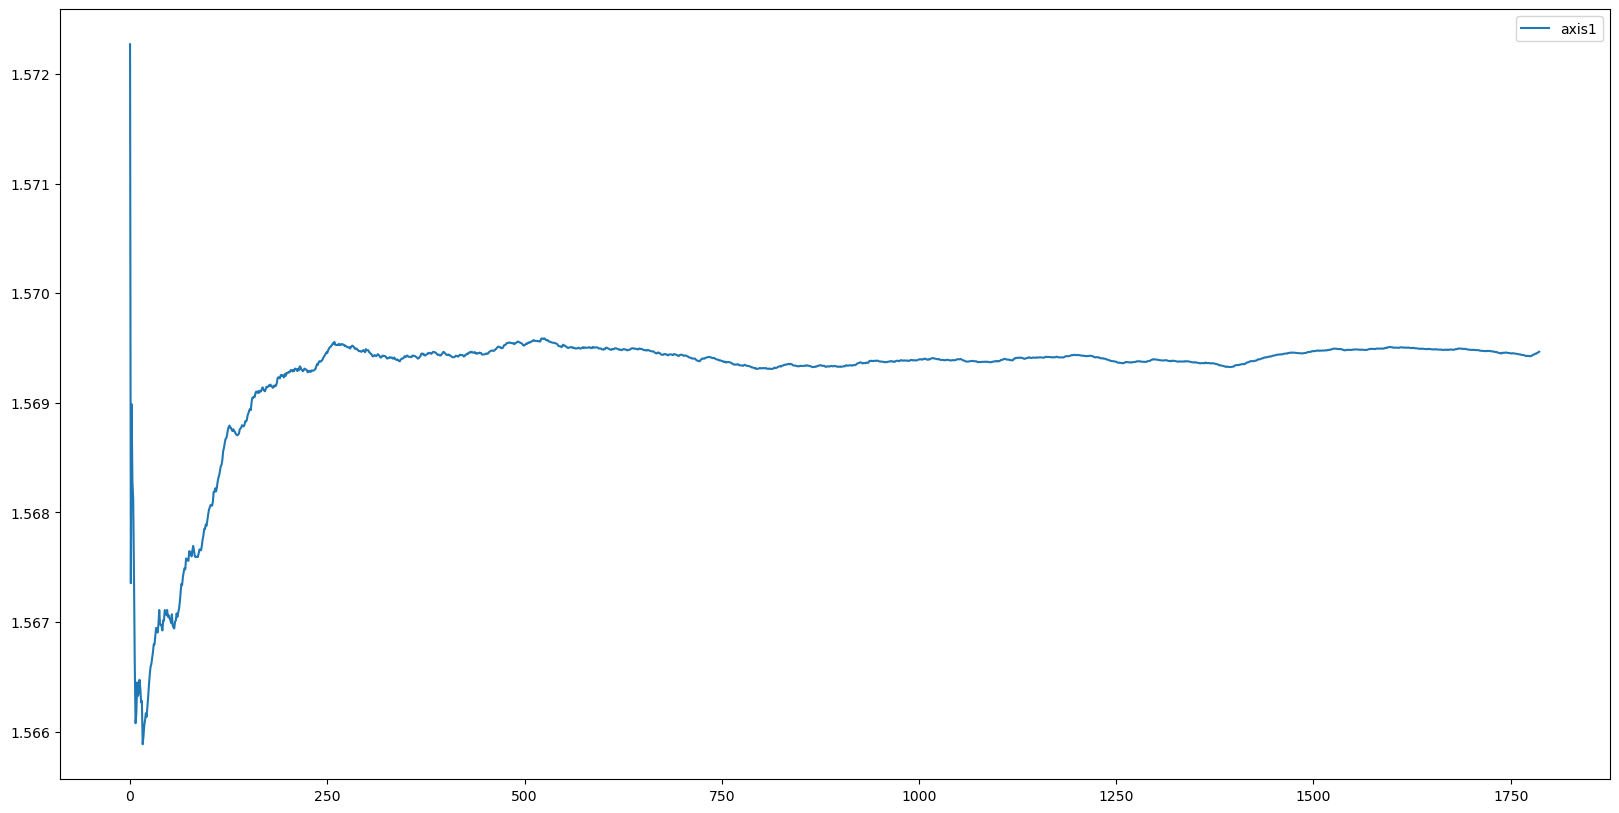

In [72]:
Crest_factor
Crest_factor.plot(y='axis1', figsize=(20,10))

In [ ]:
F2, T2, Zxx = signal.stft(t2, FREQUENCY,nperseg=40)
plt.pcolormesh(T2, F2, np.abs(Zxx), shading='auto')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()